In [23]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import minimize, Parameters

In [24]:
def calc_dist(p1, p2): 
  return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2) 

# Data Set Generation

In [25]:
true_values = np.zeros((100,106))
ranges = np.zeros((100,156))
for i in range(100) :
    k = 6
    for j in range(106) :
        true_values[i][j]  = random.randint(0,100)
        if j < 6 :
            ranges[i][j] = true_values[i][j]
        elif j >= 6 and j % 2 == 1 : 
            ranges[i][k]  = calc_dist((true_values[i][0], true_values[i][1]) , (true_values[i][j-1] ,true_values[i][j],0))
            ranges[i][k+1] = calc_dist((true_values[i][2], true_values[i][3]) , (true_values[i][j-1] ,true_values[i][j],0))
            ranges[i][k+2] = calc_dist((true_values[i][4], true_values[i][5]) , (true_values[i][j-1] ,true_values[i][j],0))
            k = k+3

        
columns1 = ["A1x" , "A1y" , "A2x" , "A2y" , "A3x" , "A3y"]

for i in range(50) :
    columns1.append("N" + str(i+1) + " x")
    columns1.append("N"  + str(i+1) + " y")

        
DF1 = pd.DataFrame( true_values , columns = columns1)

DF1.to_csv("true_locations.csv")


In [26]:
columns2  = ["A1x" , "A1y" , "A2x" , "A2y" , "A3x" , "A3y"]
for i in range(50) :
    columns2.append(str(i+1) + "- R1")
    columns2.append(str(i+1) + "- R2")
    columns2.append(str(i+1) + "- R3")
    
DF2 = pd.DataFrame( ranges , columns = columns2)

DF2.to_csv("pure_ranges.csv")

In [27]:
noisy_ranges = np.array([ranges,ranges,ranges,ranges])
mu = [0.5, 1,2]
for i in range(3) :
    for j in range(100) :
        for k in range(6,156) :
            noisy_ranges[i][j][k] = noisy_ranges[i][j][k] + np.random.normal(mu[i], 0.1)
            
R_half = pd.DataFrame( noisy_ranges[0] , columns = columns2)
R_1 = pd.DataFrame( noisy_ranges[1] , columns = columns2)
R_2 = pd.DataFrame( noisy_ranges[2] , columns = columns2)
    
R_half.to_csv("noisy_ranges_05.csv")
R_1.to_csv("noisy_ranges_1.csv")
R_2.to_csv("noisy_ranges_2.csv")




# Range Equations

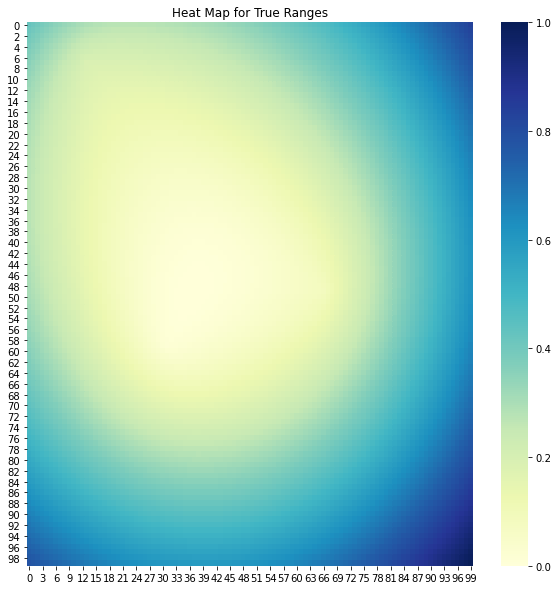

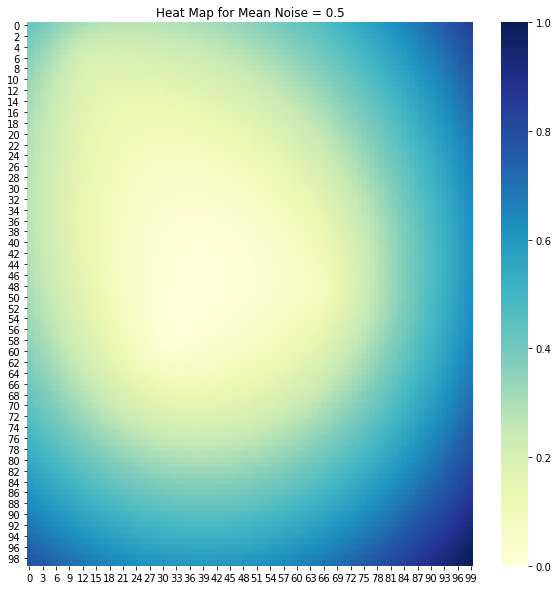

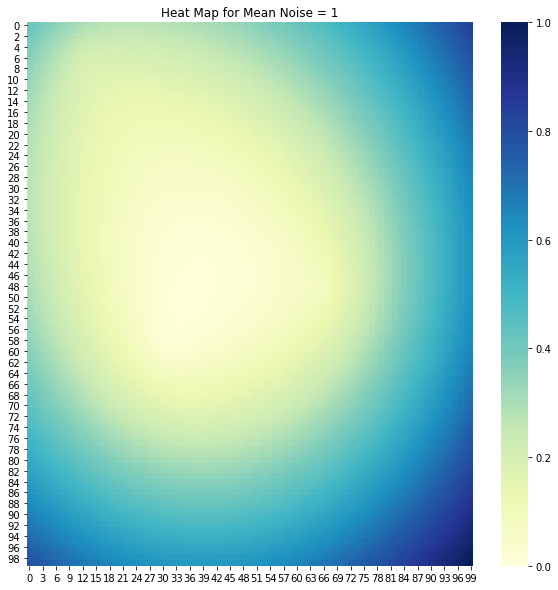

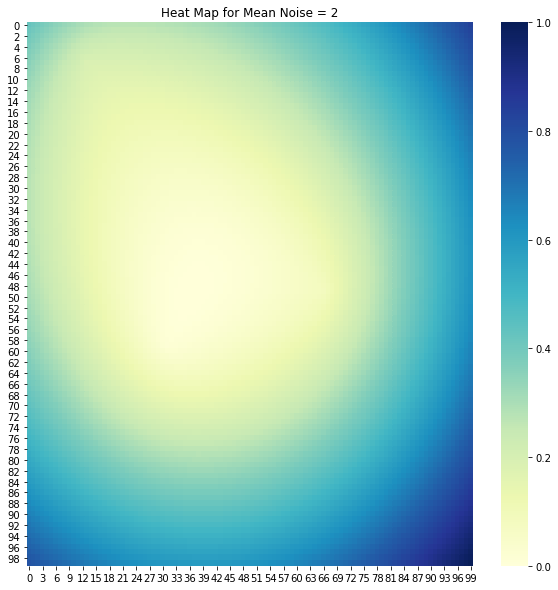

In [28]:
i = random.randint(1,100)-1
j = random.randint(1,50)-1

cost = np.zeros((4,100,100))
for r in range(4) :
    for ii in range(0,100) :
        for jj in range(0,100) :
            error = 0
            for kk in range(3) :
                error = error + calc_dist((ii,jj) , (noisy_ranges[r][i][2*kk] ,noisy_ranges[r][i][2*kk+1])) - noisy_ranges[r][i][6 + 3*(j) + kk]
            cost[r][ii][jj] = error/3
## Normalising
for r in range(4):
    mini = cost[r].min()
    maxi = cost[r].max()
    cost[r] = (cost[r] - mini) / (maxi - mini)
    
plt.figure(figsize = (10,10))
plt.title("Heat Map for True Ranges")
ax = sns.heatmap(cost[3],cmap="YlGnBu")
plt.show()

plt.figure(figsize = (10,10))
plt.title("Heat Map for Mean Noise = 0.5")
ax = sns.heatmap(cost[0],cmap="YlGnBu")
plt.show()


plt.figure(figsize = (10,10))
plt.title("Heat Map for Mean Noise = 1")
ax = sns.heatmap(cost[1],cmap="YlGnBu")
plt.show()

plt.figure(figsize = (10,10))
plt.title("Heat Map for Mean Noise = 2")
ax = sns.heatmap(cost[2],cmap="YlGnBu")
plt.show()


# Using lmfit

In [29]:
def residual(params):
    a1x=params['a1x']
    a1y=params['a1y']
    a2x=params['a2x']
    a2y=params['a2y']
    a3x=params['a3x']
    a3y=params['a3y']
    ra1=params['ra1']
    ra2=params['ra2']
    ra3=params['ra3']
    x1=params['x']
    y1=params['y']
    x=[x1,y1]
    c1=(np.linalg.norm(x- np.array([a1x,a1y]))-ra1)
    c2=(np.linalg.norm(x- np.array([a2x,a2y]))-ra2)
    c3=(np.linalg.norm(x- np.array([a3x,a3y]))-ra3)
    return np.array([c1,c2,c3])

In [30]:
e = np.zeros((4,100,50))

for i in range(100) :
    for j in range(50) :
        params = Parameters()
        params.add('a1x', value=true_values[i][0],vary=False)
        params.add('a1y', value=true_values[i][1],vary=False)
        params.add('a2x', value=true_values[i][2],vary=False)
        params.add('a2y', value=true_values[i][3],vary=False)
        params.add('a3x', value=true_values[i][4],vary=False)
        params.add('a3y', value=true_values[i][5],vary=False)
        for k in range(4) : 
            params.add('ra1', value=noisy_ranges[k][i][6 + 3*(j)],vary=False)
            params.add('ra2', value=noisy_ranges[k][i][6 + 3*(j)+1],vary=False)
            params.add('ra3', value=noisy_ranges[k][i][6 + 3*(j)+2],vary=False)
            params.add('x',value = true_values[i][6+j*2],max = 99,min = 0)
            params.add('y',value = true_values[i][6+j*2+1],max = 99,min = 0)
            out = minimize(residual, params)
            fit = residual(out.params)
            e[k][i][j] = calc_dist((true_values[i][6+j*2],true_values[i][6+j*2+1]) , (round(out.params['x'].value) , round(out.params['y'].value)))


<AxesSubplot:ylabel='Proportion'>

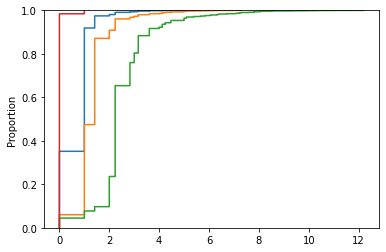

In [31]:
sns.ecdfplot(e[0].reshape(5000))
sns.ecdfplot(e[1].reshape(5000))
sns.ecdfplot(e[2].reshape(5000))
sns.ecdfplot(e[3].reshape(5000))

In [32]:
print("For true ranges:")
print("Median error:",end=' ')
print(np.median(e[3].reshape(5000)))
print("75th percentile error:",end=' ')
print(np.percentile(np.array(e[3].reshape(5000)),75))
print("95th percentile error:",end=' ')
print(np.percentile(np.array(e[3].reshape(5000)),95))

print("For noisy ranges 0.5:")
print("Median error:",end=' ')
print(np.median(e[0].reshape(5000)))
print("75th percentile error:",end=' ')
print(np.percentile(np.array(e[0].reshape(5000)),75))
print("95th percentile error:",end=' ')
print(np.percentile(np.array(e[0].reshape(5000)),95))

print("For noisy ranges 1:")
print("Median error:",end=' ')
print(np.median(e[1].reshape(5000)))
print("75th percentile error:",end=' ')
print(np.percentile(np.array(e[1].reshape(5000)),75))
print("95th percentile error:",end=' ')
print(np.percentile(np.array(e[1].reshape(5000)),95))

print("For noisy ranges 2:")
print("Median error:",end=' ')
print(np.median(e[2].reshape(5000)))
print("75th percentile error:",end=' ')
print(np.percentile(np.array(e[2].reshape(5000)),75))
print("95th percentile error:",end=' ')
print(np.percentile(np.array(e[2].reshape(5000)),95))



For true ranges:
Median error: 0.0
75th percentile error: 0.0
95th percentile error: 0.0
For noisy ranges 0.5:
Median error: 1.0
75th percentile error: 1.0
95th percentile error: 1.4142135623730951
For noisy ranges 1:
Median error: 1.4142135623730951
75th percentile error: 1.4142135623730951
95th percentile error: 2.23606797749979
For noisy ranges 2:
Median error: 2.23606797749979
75th percentile error: 2.8284271247461903
95th percentile error: 4.47213595499958


# Task 4

In [33]:
medians = np.zeros((4,100))

for i in range(4) :
    for j in range(100) :
        medians[i][j] = np.median(e[i][j])

print(medians)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         0.5
  1.         0.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         0.         1.         1.         1.
  0.5        1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  0.         1.         1.         1.         0.5        1.
  0.         1.         1.         1.         0.         0.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         0.5
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1. 

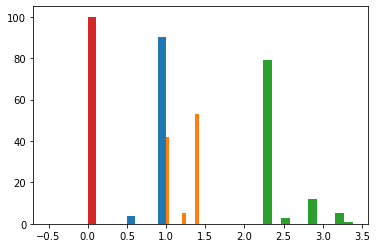

In [34]:
plt.figure()
plt.hist(medians[0])
plt.hist(medians[1])
plt.hist(medians[2])
plt.hist(medians[3])

plt.show()

In [35]:
result1 = np.where(medians[2] == np.amax(medians[2]))
result2 = np.where(medians[1] == np.amax(medians[1]))
result3 = np.where(medians[0] == np.amax(medians[0]))

In [36]:
print(result1[0],result2[0],result3[0])

print(true_values[93][0],true_values[93][2],true_values[93][4])
print(true_values[93][1],true_values[93][3],true_values[93][5])

[56] [ 0  4  5  6  9 12 14 15 16 17 19 20 21 22 23 24 27 28 30 33 34 35 36 38
 40 43 46 47 49 51 53 56 57 58 62 64 68 69 73 74 76 82 86 87 88 91 92 94
 95 96 97 98 99] [ 0  1  2  3  4  5  6  7  8  9 10 12 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 61 62 63 65 67 68 69 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 90 91 92 93 94 95 96 97 98 99]
19.0 92.0 51.0
99.0 79.0 91.0


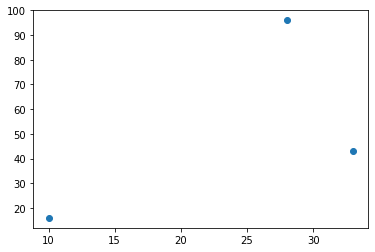

In [37]:
#The anchor points are 
plt.figure()
x = [true_values[84][0],true_values[84][2],true_values[84][4]]
y =[true_values[84][1],true_values[84][3],true_values[84][5]]
plt.scatter(x,y)
plt.show()

In [16]:
#Two of them are collinear and hence max error was obtained in the case of anchor point choice 93